In [1]:
import operator
from langgraph.types import Send
from typing_extensions import Annotated, TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
import os
from dotenv import load_dotenv

load_dotenv(dotenv_path="../../.env")

llm = init_chat_model("ollama:gpt-oss:120b", base_url=os.environ.get("OLLAMA_BASE_URL"))


class State(TypedDict):
    document: str
    final_summary: str
    summaries: Annotated[list[dict], operator.add]

In [2]:
def summarize_paragraph(state):
    paragraph = state["paragraph"]
    index = state["index"]
    response = llm.invoke(
        f"""
        Write a 3 sentence summary of this paragraph {paragraph}
        """
    )
    return {
        "summaries": [
            {
                "index": index,
                "summary": response.content,
            }
        ],
    }


def dispatch_summarizer(state: State):
    chunks = state["document"].split("\n")
    return [
        Send("summarize_paragraph", {"paragraph": chunk, "index": index})
        for index, chunk in enumerate(chunks)
    ]


def final_summary(state: State):
    response = llm.invoke(
        f"Using the following summaries, give me a final one {state['summaries']}"
    )
    return {"final_summary": response.content}

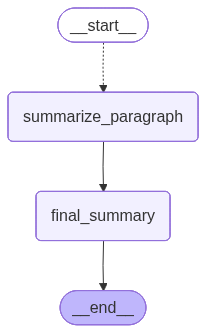

In [3]:
graph_builder = StateGraph(State)

graph_builder.add_node("summarize_paragraph", summarize_paragraph)
graph_builder.add_node("final_summary", final_summary)

graph_builder.add_conditional_edges(START, dispatch_summarizer, ["summarize_paragraph"])
graph_builder.add_edge("summarize_paragraph", "final_summary")
graph_builder.add_edge("final_summary", END)


graph = graph_builder.compile()

graph

In [4]:
with open("fed_transcript.md", "r", encoding="utf-8") as file:
    document = file.read()

for chunk in graph.stream(
    {
        "document": document,
    },
    stream_mode="updates",
):
    print(chunk, "\n")

{'summarize_paragraph': {'summaries': [{'index': 1, 'summary': 'Sure! Please paste the paragraph you’d like summarized, and I’ll condense it into three sentences for you.'}]}} 

{'summarize_paragraph': {'summaries': [{'index': 13, 'summary': 'Sure! Could you please provide the paragraph you’d like summarized? Once I have it, I’ll craft a concise three‑sentence summary for you.'}]}} 

{'summarize_paragraph': {'summaries': [{'index': 2, 'summary': 'Recent data show that economic activity is slowing down. Gross domestic product (GDP) grew by about 1.5\u202f% in the first half of the year, a noticeable drop from the 2.5\u202f% growth recorded during the same period last year. This decline indicates a moderation in the overall pace of the economy’s expansion.'}]}} 

{'summarize_paragraph': {'summaries': [{'index': 6, 'summary': 'Business investment is growing again after a slowdown.\u202fSpending on equipment and intangible assets has risen compared with the previous year’s levels.\u202fThi

In [5]:
llm = init_chat_model("openai:gpt-4o")

with open("fed_transcript.md", "r", encoding="utf-8") as file:
    document = file.read()

for chunk in graph.stream(
    {
        "document": document,
    },
    stream_mode="updates",
):
    print(chunk, "\n")

{'summarize_paragraph': {'summaries': [{'index': 9, 'summary': 'Sure, please provide the paragraph you would like summarized.'}]}} 

{'summarize_paragraph': {'summaries': [{'index': 7, 'summary': "Of course! Please provide the paragraph you'd like summarized."}]}} 

{'summarize_paragraph': {'summaries': [{'index': 11, 'summary': "Certainly! Please provide the paragraph you'd like summarized."}]}} 

{'summarize_paragraph': {'summaries': [{'index': 3, 'summary': "Of course! Please provide the paragraph you'd like summarized, and I'll be happy to help."}]}} 

{'summarize_paragraph': {'summaries': [{'index': 1, 'summary': 'Please provide the paragraph you would like summarized, and I will be happy to help you with that.'}]}} 

{'summarize_paragraph': {'summaries': [{'index': 13, 'summary': "Of course! Please provide the paragraph you'd like me to summarize."}]}} 

{'summarize_paragraph': {'summaries': [{'index': 5, 'summary': 'Of course! Please provide the paragraph that you would like sum